# Initial experiment: small vanilla transformer (NanoGPT) trained on plain addition

In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import math
from pathlib import Path


import torch
import lightning as L
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader

from arithmetic_lm.tokenizer import CharTokenizer, Tokenizer
from arithmetic_lm.utils import get_torch_device, set_seed
from arithmetic_lm.constants import DATA_DIR

In [3]:
DEVICE = get_torch_device()
print(f"Using device: {DEVICE}")

set_seed(1337)

Using device: mps


## NanoGPT model

In [4]:
# from https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, max_len: int, dropout: float):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [5]:
class NanoGPT(nn.Module):
    """Simple small decoder-only transformer model using nn.TransformerDecoder."""

    def __init__(
        self,
        context_len: int,
        n_embd: int,
        n_head: int,
        n_layers: int,
        vocab_size: int,
        ff_factor: int = 4,
        dropout: float = 0.1,
    ):
        """
        Arguments:
            context_len: context length, i.e. the number of expected features in the input
            n_embd: dimensionality of model embeddings
            n_head: number of heads in the multi-head attention
            n_layers: number of nn.TransformerDecoderLayer layers
            vocab_size: size of the vocabulary
            ff_factor: factor by which to scale the hidden layer dimensionality in the feedforward layer
            dropout: dropout probability
        """

        super().__init__()
        self.context_len = context_len
        self.n_embd = n_embd
        self.n_head = n_head
        self.n_layers = n_layers
        self.vocab_size = vocab_size
        self.ff_factor = ff_factor
        self.dropout = dropout

        # embedding
        self.embedding = nn.Embedding(vocab_size, n_embd)
        self.pos_encoder = PositionalEncoding(n_embd, max_len=context_len, dropout=dropout)

        # same as decoder layer essentially, but without cross attention
        self.layer = nn.TransformerEncoderLayer(
            d_model=n_embd,
            nhead=n_head,
            dim_feedforward=n_embd * ff_factor,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.layer,
            num_layers=n_layers,
            norm=nn.LayerNorm(n_embd),
        )

        # output to vocab dim
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)

        # weight tying
        self.lm_head.weight = self.embedding.weight

        # TODO init weights
    
    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len]``
        
        Returns:
            logits: Tensor, shape ``[batch_size, seq_len, vocab_size]``
        """
        x = self.embedding(x)
        x = self.pos_encoder(x)

        x = self.transformer_encoder(
            x,
            is_causal=True,
            mask=nn.Transformer.generate_square_subsequent_mask(
                self.context_len, device=x.device
            ),
        )
        x = self.lm_head(x)
        return x
    
    @torch.no_grad()
    def generate(
        self,
        idx: Tensor,
        max_new_tokens: int,
        temperature: float = 1.0,
        top_k: int = None,
        stop_token: int = None
    ) -> Tensor:
        """
        Take a conditioning sequence of indices idx (tensor of shape [batch, seq_len]) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        assert isinstance(idx, torch.Tensor), "idx must be a torch.Tensor"
        assert idx.dim() == 2, "idx must be a 2D tensor of shape [batch, seq_len]"
        assert idx.size(1) <= self.context_len, "sequence length must be <= context_len"
        assert idx.size(0) == 1, "only batch_size=1 is supported for now"
        for _ in range(max_new_tokens):
            # crop to context_len if necessary
            idx_cond = idx if idx.size(1) <= self.context_len else idx[:, -self.context_len:]

            # logits shape: [batch, seq_len, vocab_size]
            logits = self.forward(idx_cond)

            # get logits at final step and apply temperature
            logits = logits[:, -1, :] / temperature

            # optionally apply top-k filtering
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float("inf")

            # apply softmax
            probs = nn.functional.softmax(logits, dim=-1)

            # sample from the distribution
            next_token = torch.multinomial(probs, num_samples=1)

            # append to the sequence
            idx = torch.cat([idx, next_token], dim=1)

            # stop if stop_token is generated
            if stop_token is not None and next_token.item() == stop_token:
                break
        return idx

In [6]:
net = NanoGPT(
    context_len=10,
    n_embd=32,
    n_head=4,
    n_layers=2,
    vocab_size=100,
    ff_factor=4,
    dropout=0.1,
).to(DEVICE)

# test forward pass
x = torch.randint(0, 100, (8, 10)).to(DEVICE) # (batch_size, seq_len)
y = net(x)
y.shape # (batch_size, seq_len, vocab_size)

torch.Size([8, 10, 100])

In [7]:
net

NanoGPT(
  (embedding): Embedding(100, 32)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
    (linear1): Linear(in_features=32, out_features=128, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=128, out_features=32, bias=True)
    (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_

## Test one batch overfitting

In [8]:
tokenizer = CharTokenizer()

In [9]:
text = "hello world"
tokens = tokenizer.encode(text)
tokens, "len:", len(tokens), tokenizer.decode(tokens)

([17, 14, 21, 21, 24, 94, 32, 24, 27, 21, 13], 'len:', 11, 'hello world')

In [10]:
# convert to tensor
tokens = torch.tensor(tokens).unsqueeze(0).to(DEVICE)
tokens.shape

torch.Size([1, 11])

In [11]:
# simplest train loop
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# create target by shifting tokens by 1 and adding a padding token at the end
target = torch.cat([tokens[0, 1:], torch.tensor([65]).to(DEVICE)]).unsqueeze(0)
test_text = "hel"
test_tokens = tokenizer.encode(test_text)
test_tokens = torch.tensor(test_tokens).unsqueeze(0).to(DEVICE)

losses = []

for i in range(500):
    optimizer.zero_grad()
    y = net(tokens)
    # y shape: (batch_size, seq_len, vocab_size)
    loss = criterion(y.view(-1, y.size(-1)), target.view(-1))
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if i % 50 == 0:
        print(f"[{i}] loss: {loss.item():.5f}  ", test_text + " -> " + tokenizer.decode(net.generate(test_tokens, max_new_tokens=10).squeeze().tolist()))

[0] loss: 19.35489   hel -> helWWWWWWWWWW
[50] loss: 0.83771   hel -> helld$$$Uworl
[100] loss: 0.58493   hel -> hello world$$
[150] loss: 0.05192   hel -> helo world$$$
[200] loss: 0.15249   hel -> helllo world$
[250] loss: 0.06614   hel -> helllo world$
[300] loss: 0.07330   hel -> hello world$$
[350] loss: 0.44040   hel -> hellllo world
[400] loss: 0.00855   hel -> helo world$$$
[450] loss: 0.01260   hel -> hello world$$


Text(0, 0.5, 'loss')

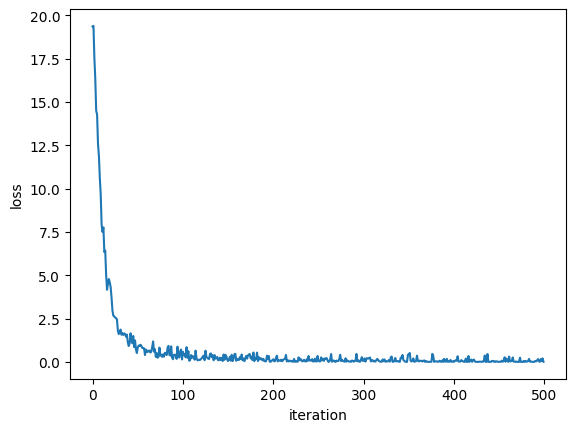

In [12]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(losses)
plt.xlabel("iteration")
plt.ylabel("loss")

In [13]:
test_prompt = "hell"
tokens = tokenizer.encode(test_prompt)
tokens = torch.tensor(tokens).unsqueeze(0).to(DEVICE)
print(tokens.shape)

net.eval()
generated_tokens = net.generate(tokens, max_new_tokens=10, temperature=1.0, top_k=10)
print(generated_tokens.shape)

tokenizer.decode(generated_tokens.squeeze(0).cpu().tolist())

torch.Size([1, 4])
torch.Size([1, 14])


'hello world$$$'

## Dataset

In [14]:
SEQ_LEN = 16
BATCH_SIZE = 32

In [15]:
class ArithmeticDataset(Dataset):
    # TODO transforms (adding $, formatting,)
    def __init__(self, txtfile: str | Path, tokenizer: Tokenizer, seq_len: int):
        self.tokenizer = tokenizer
        self.seq_len = seq_len
        with open(txtfile, "r") as f:
            text = f.read()
        tokens = self.tokenizer.encode(text)
        # make batches of same length (truncate if necessary)
        n_batches = len(tokens) // seq_len
        self.batches = [tokens[i*seq_len:(i+1)*seq_len] for i in range(n_batches)]

    def __len__(self) -> int:
        return len(self.batches)

    def __getitem__(self, idx: int) -> list[int]:
        # return tensors
        return torch.tensor(self.batches[idx])

In [16]:
# 2k balanced dataset
total_ds = ArithmeticDataset(DATA_DIR / "add_3digit" / "add_3digit_2k_bal.txt" , CharTokenizer(), seq_len=SEQ_LEN)
print("total:", len(total_ds), "batches")

# train/val split
train_ds, val_ds = torch.utils.data.random_split(total_ds, [0.8, 0.2], generator=torch.Generator().manual_seed(42))
print("train:", len(train_ds))
print("val:", len(val_ds))
print("train[0]:", tokenizer.decode(train_ds[0].tolist()))
print("type(train_ds[0]):", type(train_ds[0]))

del total_ds

total: 1473 batches
train: 1179
val: 294
train[0]: 232=1110
333+569
type(train_ds[0]): <class 'torch.Tensor'>


In [17]:
ldm = L.LightningDataModule.from_datasets(train_dataset=train_ds, val_dataset=val_ds, batch_size=BATCH_SIZE)

In [18]:
for b in ldm.train_dataloader():
    print(b.shape)
    # split into input and target
    x, y = b[:, :-1], b[:, 1:]
    print(x.shape, y.shape)
    print(tokenizer.decode(x[0].tolist()))
    for i, o in zip(tokenizer.decode(x[0].tolist()), tokenizer.decode(y[0].tolist())):
        print(i, "->", o)
    break

torch.Size([32, 16])
torch.Size([32, 15]) torch.Size([32, 15])
38+81=119
98+70
3 -> 8
8 -> +
+ -> 8
8 -> 1
1 -> =
= -> 1
1 -> 1
1 -> 9
9 -> 


 -> 9
9 -> 8
8 -> +
+ -> 7
7 -> 0
0 -> =


## Lightning module wrapper for model

In [19]:
class LightningNanoGPT(L.LightningModule):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.model = NanoGPT(*args, **kwargs)

    def forward(self, x: Tensor) -> Tensor:
        return self.model(x)
    
    def training_step(self, batch: Tensor, batch_idx: int) -> Tensor:
        # batch: (batch_size, seq_len)
        # split into input and target (shifted by 1)
        x, y = batch[:, :-1], batch[:, 1:]
        # forward pass
        logits = self.model(x)
        # calculate loss
        loss = nn.functional.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
        self.log("train_loss", loss, on_step=True)
        return loss
    
    def validation_step(self, batch: Tensor, batch_idx: int) -> Tensor:
        x, y = batch[:, :-1], batch[:, 1:]
        logits = self.model(x)
        loss = nn.functional.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
        self.log("val_loss", loss, on_step=True)
        return loss
    
    def test_step(self, batch: Tensor, batch_idx: int) -> Tensor:
        raise NotImplementedError("Test step not implemented")